In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.expand_frame_repr', False)

In [4]:
from helper.eda import (
    dataframe_info, check_mapping
)

## Load Data

Observation on columns:
1. tweet_id : unique identifier for Tweets
2. tweet_text : (str) text content of Tweets
3. topic : (str) topic name
4. label : (int) label numbers tied to topic name 

In [15]:
df=pd.read_excel('./dataset/Q2 Dataset.xlsx', engine='openpyxl')
dataframe_info(df)
df.sample(n=6)

INFO : DataFrame has 10558 rows and 4 columns
INFO : Column Names are Index(['tweet_id', 'tweet_text', 'topic', 'label'], dtype='object')


tweet_id                                         tweet_text                      topic  label
5996   1250135651502128896  When doing good, you should do it because you ...  not_related_or_irrelevant      7
2154  '462736440871239680'  #Edwincito 10 Questions on the Deadly Middle E...   other_useful_information      6
3484   1245724293104833024  HOW TO PROPERLY WEAR AN N95 MASK (RESPIRATOR) ...                 prevention      2
7963   1251193238326857984  RT @SenRickScott: “Didn’t look”? Really? \n\nT...  not_related_or_irrelevant      7
7748   1250481408012780032  RT @mkabhijit2: @wanderlustyogi @Reed39040614 ...  not_related_or_irrelevant      7
5896   1250135502201803008  If you are 65 or older, you are at a higher ri...                 prevention      2

## Preprocessing
1. Drop Tweet ID
2. Check for Nulls
3. Check for Duplications

In [17]:
df.isna().sum()

tweet_id      26
tweet_text     0
topic          0
label          0
dtype: int64

In [82]:
df=df.drop('tweet_id', axis=1)
print('INFO : Column "tweet_id" dropped from Dataframe')

INFO : Column "tweet_id" dropped from Dataframe


In [83]:
print(f'INFO : Found {df.duplicated().sum()} duplicated rows')
df=df[~df.duplicated()]
dataframe_info(df)

INFO : Found 1239 duplicated rows
INFO : DataFrame has 9319 rows and 3 columns
INFO : Column Names are Index(['tweet_text', 'topic', 'label'], dtype='object')


## Check Mapping
Check Topic => Label mapping

Ensure 1:1 Mapping

In [56]:
_ = check_mapping(df)

INFO : 6=>['other_useful_information']
INFO : 3=>['treatment']
INFO : 1=>['disease_transmission']
INFO : 0=>['disease_signs_or_symptoms']
INFO : 7=>['not_related_or_irrelevant']
INFO : 2=>['prevention']
INFO : 4=>['deaths_reports']
INFO : 5=>['affected_people']


# Check Class Distribution
Class distribution mildly imbalanced. 

Apply "class_weight" = "balanced" during training

Evaluate "balanced_accuracy_score" as metrics

Largest class is "not_related_or_irrelevant"

Smallest class is "disease_signs_or_symptoms"

In [57]:
df['topic'].value_counts()

not_related_or_irrelevant    3592
other_useful_information     1880
affected_people              1031
deaths_reports                643
treatment                     640
prevention                    579
disease_transmission          525
disease_signs_or_symptoms     429
Name: topic, dtype: int64

/Users/jerome/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'not_related_or_irrelevant'),
  Text(1, 0, 'other_useful_information'),
  Text(2, 0, 'affected_people'),
  Text(3, 0, 'deaths_reports'),
  Text(4, 0, 'treatment'),
  Text(5, 0, 'prevention'),
  Text(6, 0, 'disease_transmission'),
  Text(7, 0, 'disease_signs_or_symptoms')])

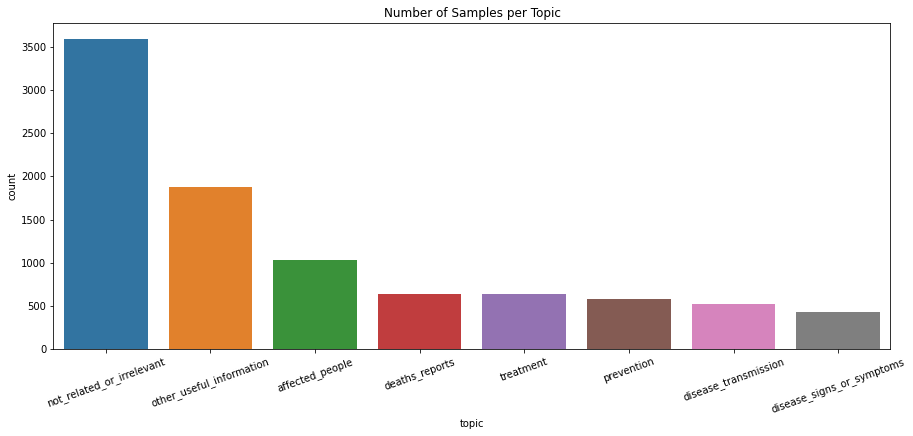

In [58]:
fig,ax = plt.subplots(figsize=(15, 6))
sns.countplot(
    df['topic'],
    order=df['topic'].value_counts().index
).set_title('Number of Samples per Topic')
plt.xticks(rotation=20)

## General Text Cleaning

Remove @[username]

Remove RT ( means re-tweet)
    
Remove Web URLs
    
For BERT based : Remove hashtag sign but keep the text

For Simple Text : Remain hashtag

In [84]:
from helper.cleaner import clean_general

In [86]:
df['tweet_text_ori'] = df['tweet_text']
df['tweet_text'] = df['tweet_text_ori'].apply(lambda x : clean_general(x) )

/Users/jerome/.pyenv/versions/3.7.3/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [93]:
df=df[['label', 'topic', 'tweet_text_ori', 'tweet_text']]
df.head()

label                     topic                                     tweet_text_ori                                         tweet_text
0      6  other_useful_information  RT @QuestionsNG: Ebola is not gonna come close...  Ebola is not going to come close to you  your ...
1      3                 treatment  It's too funny to watch MSNBC put an infectiou...  It is too funny to watch MSNBC put an infectio...
2      6  other_useful_information  RT @mikecalma: How the #GOP fights infectious ...     How the  GOP fights infectious disease   Ebola
3      6  other_useful_information  @drbrainbugz it's all about spin! Guaranteed t...  it is all about spin  Guaranteed though questi...
4      1      disease_transmission  WHO officially declares that #Senegal has ende...  WHO officially declares that  Senegal has ende...

# Check Text Lengths
### Words
3 < Number of Words (Pre-Clean) < 40

0 < Number of Words (Post-Clean) < 38

### Characters
3 < Number of Chars (Pre-Clean) < 40

0 < Number of Chars (Post-Clean) < 38

In [72]:
df['num_words'] = df['tweet_text'].apply(lambda x:len(x.split()))
df['num_chars'] = df['tweet_text'].apply(lambda x:len(x))
df['num_words_ori'] = df['tweet_text_ori'].apply(lambda x:len(x.split()))
df['num_chars_ori'] = df['tweet_text_ori'].apply(lambda x:len(x))

In [76]:
for col in ['num_words_ori', 'num_words']:
    print(col.title())
    print(df[col].describe())

Num_Words_Ori
count    9319.000000
mean       18.622170
std         4.370832
min         3.000000
25%        16.000000
50%        19.000000
75%        22.000000
max        40.000000
Name: num_words_ori, dtype: float64
Num_Words
count    9319.000000
mean       16.416783
std         4.573494
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        38.000000
Name: num_words, dtype: float64


In [75]:
for col in ['num_chars_ori', 'num_chars']:
    print(col.title())
    print(df[col].describe())

Num_Chars_Ori
count    9319.000000
mean      130.650606
std        18.791071
min        25.000000
25%       130.000000
50%       140.000000
75%       140.000000
max       181.000000
Name: num_chars_ori, dtype: float64
Num_Chars
count    9319.000000
mean      103.001932
std        22.716791
min         0.000000
25%        90.000000
50%       110.000000
75%       120.000000
max       197.000000
Name: num_chars, dtype: float64


## Deal with Empty Text

In [77]:
df_no_words=df[df['num_words']==0]
print(f"{df_no_words.shape[0]} Rows with 0 words")
print('Topics with 0 words ')
print(df_no_words['topic'].value_counts())

13 Rows with 0 words
Topics with 0 words 
not_related_or_irrelevant    13
Name: topic, dtype: int64


In [21]:
df=df[~(df['tweet_text']=='')] #Remove rows with 0 words

In [80]:
df[['tweet_text','topic','label']].to_json('./dataset/Q2_Dataset.cleaned-general.json')

Text(0.5, 1.0, 'Histogram Number of Words')

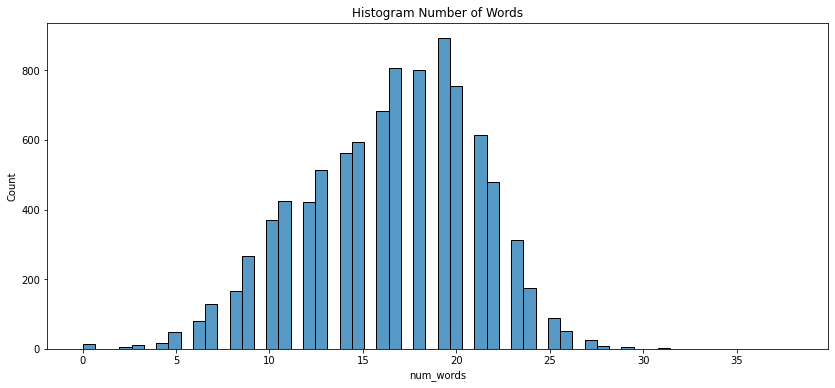

In [79]:
fig,ax = plt.subplots(figsize=(14, 6))
sns.histplot(df['num_words'], ax=ax).set_title('Histogram Number of Words')
# plt.legend(labels=['NewPrice', 'Sold_Amount'])

## Topics vs Word Length
No significant difference found in Average Word Lengths across Topics

In [15]:
avg_words_topic=df.groupby(['topic']).mean()['num_words'].sort_values()

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'disease_signs_or_symptoms'),
  Text(1, 0, 'treatment'),
  Text(2, 0, 'disease_transmission'),
  Text(3, 0, 'other_useful_information'),
  Text(4, 0, 'affected_people'),
  Text(5, 0, 'not_related_or_irrelevant'),
  Text(6, 0, 'prevention'),
  Text(7, 0, 'deaths_reports')])

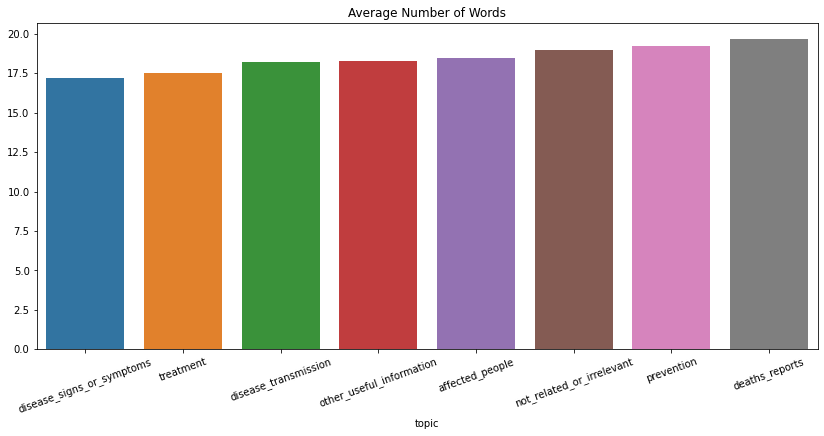

In [16]:
fig,ax = plt.subplots(figsize=(14, 6))
sns.barplot(x=avg_words_topic.index, y=avg_words_topic.values,ax=ax).set_title('Average Number of Words')
plt.xticks(rotation=20)

In [98]:
# Peek at shortest Tweets
# df.sort_values('num_words')[:12]

## Peek at Data Samples

Observation on Topics:
- Other_Useful_Information : Quite varied. about disease affecting regional politics, economies, daily lives & routines, charity
- Treatment : Treatment centres, latest treatments, testing, efficacies, etc.
- Disease Transmission : Infection on Kids & Adults, quarintine, cause and ease of spread, risks of transmission
- Disease Signs or Symptoms : Symptoms & conditions like Cough, Fever, Shortness of breath, Stomach Pain, etc.
- Not_Related_Or_Irrelevant : Touch on shift in lifestyle, social distancing, or even entertainment industry
- Prevention : Recommendations on preventions, social distancing, increasing immune system, stay clean, etc.
- Death Reports : Death tolls / count in specific region, country, district, building
- Affected_People : Members of Communities in specific region, country, district, building

It's observed that some topics have higher chance of overlap ( models will struggle ).
Examples:
- Death Reports & Affected People
- Not_Related_Or_Irrelevant & Other_Useful_Information

In [5]:
df=pd.read_json('./dataset/Q2_Dataset.cleaned-general.json')

In [111]:
for topic in df['topic'].unique():
    print('=+'*20)
    print(topic.title())
    print(df[df.topic==topic].sample(n=8)['tweet_text'].values)

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Other_Useful_Information
['While Tony Abbott waits for  Ebola to get to  Australia  President Obama attacks the disease at the source   auspol'
 'Ann Coulter calls Africa a  disease ridden cesspool  in victim blaming Ebola rant'
 'Manitobans living outside of Winnipeg are reminded not to call  for COVID  related issues  Reports of non complianc   '
 'Democrats are so desperate to blame President Trump that they are now DEFENDING Communist China  China and the l   '
 'Dr  Desai  CoronavirusUSA cannot  FlattenTheCurve if not strictly federal mandated  FullLockdown like  SKor   '
 ' MERS Search  Disease Detectives Beat Bushes for Virus   HealthNews'
 'It has been established  China has been lying for months  China knew  allowed   spread  Coronavirus worldwide  Wuhan la   '
 '  is seeking donations please to its  COVID Emergency Appeal  as the charity confirms PSm additional fund   ']
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Treatment
['Gilead s Ant

## TFIDF N-grams

Each Topic, filter out Top-10 Scoring Words for 1-Gram, 2-Gram, 3-Gram

Observations : 
- Anomoly detected. While it's stated that this is a COVID Dataset, it includes other infectious diseases namely EBOLA & MERS

In [18]:
from helper.eda import peek_tfidf, plot_wordcloud

In [96]:
top = 10 # Top-M Scoring Words
for topic in df['topic'].unique():
    print('=+'*20)
    print(f'Topic : {topic.title()}')
    text_series = df[df['topic']==topic]['tweet_text']
    for n in range(1,4):
        print(f'[ Top {n}-Gram ]')
        top_ngrams = peek_tfidf(text_series, top=top, ngram_range=(n,n))['term'].values
        print(f">> {' | '.join(top_ngrams)}")

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Topic : Other_Useful_Information
[ Top 1-Gram ]
>> the | to | ebola | disease | in | of | mers | is | coronavirus | on
[ Top 2-Gram ]
>> on the | deadly middle | questions on | virus that | the deadly | up in | middle eastern | showed up | in indiana | that showed
[ Top 3-Gram ]
>> on the deadly | showed up in | the deadly middle | middle eastern virus | that showed up | virus that showed | eastern virus that | deadly middle eastern | questions on the | up in indiana
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Topic : Treatment
[ Top 1-Gram ]
>> ebola | treatment | the | to | for | of | in | coronavirus | is | and
[ Top 2-Gram ]
>> ebola treatment | for treatment | for ebola | treatment for | ebola virus | of the | treatment of | with ebola | to be | coronavirus vaccine
[ Top 3-Gram ]
>> for ebola treatment | obscure biotech firm | biotech firm hurries | hurries ebola treatment | an obscure biotech | firm hurries ebola | ebola like symptoms | treat

### Wordcloud

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Topic : Other_Useful_Information


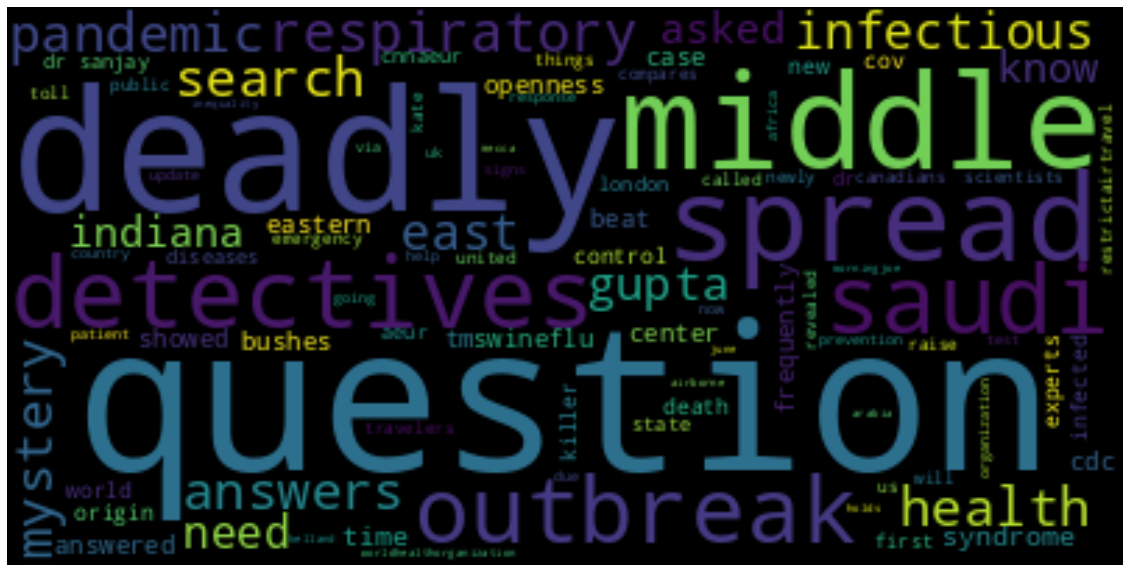

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Topic : Treatment
INFO : Saved Image of Confusion Matrix at  ./plot/wordcloud_treatment


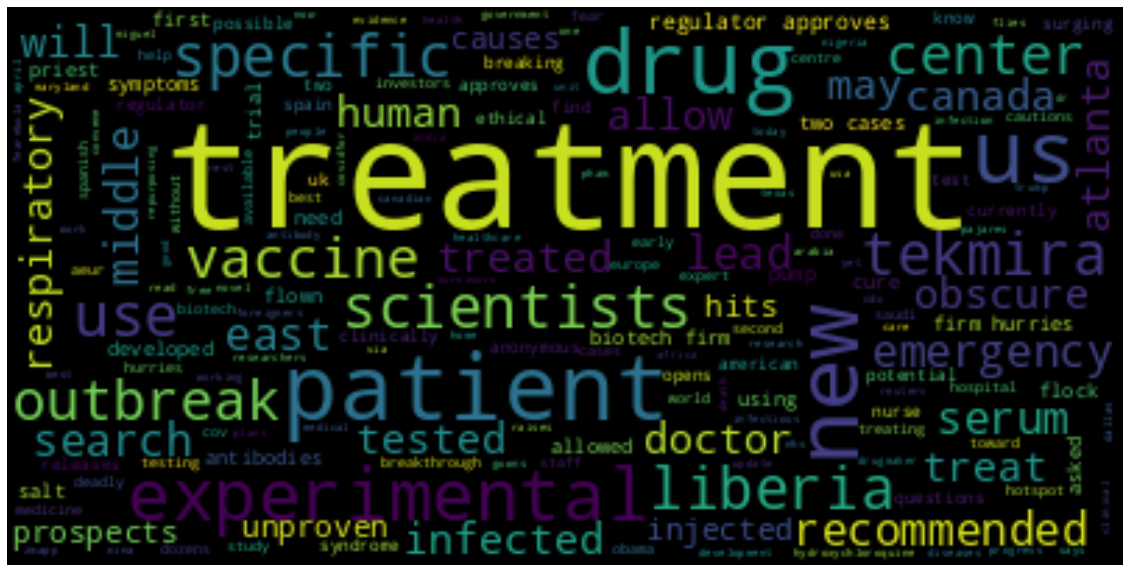

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Topic : Disease_Transmission
INFO : Saved Image of Confusion Matrix at  ./plot/wordcloud_disease_transmission


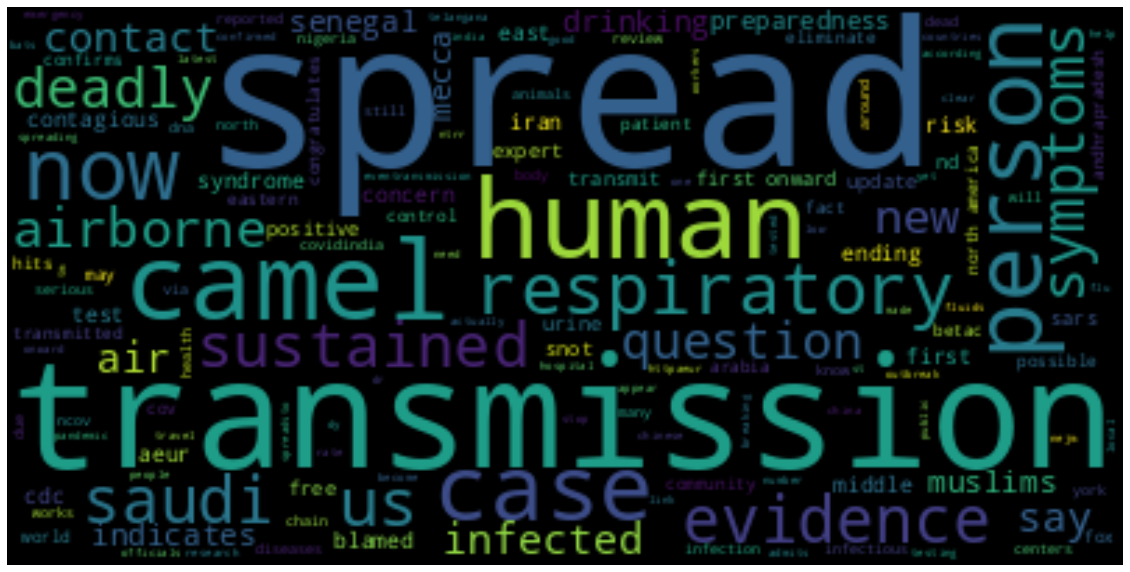

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Topic : Disease_Signs_Or_Symptoms
INFO : Saved Image of Confusion Matrix at  ./plot/wordcloud_disease_signs_or_symptoms


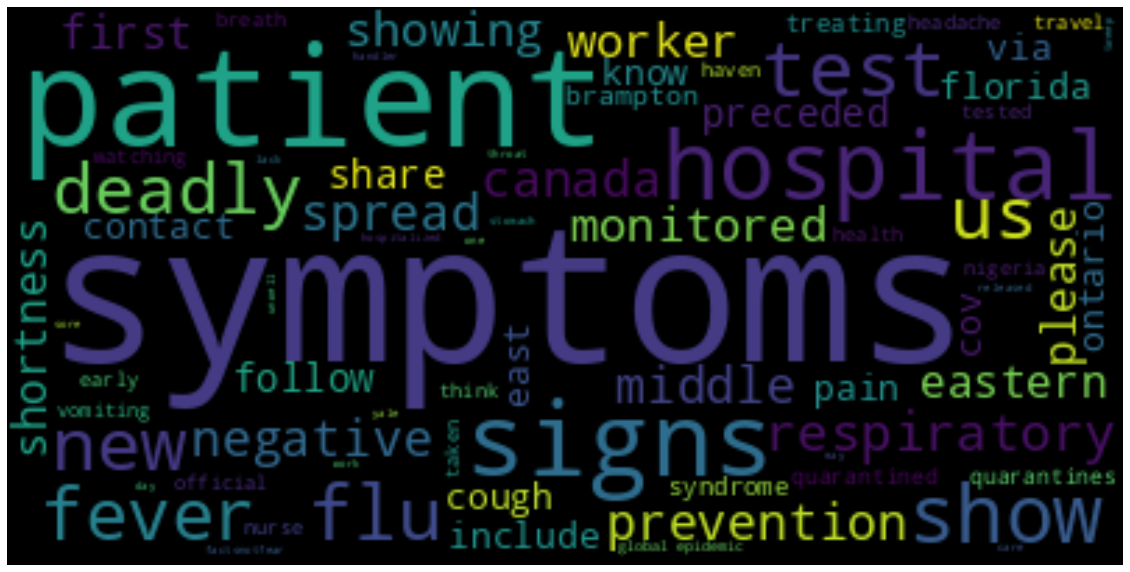

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Topic : Not_Related_Or_Irrelevant
INFO : Saved Image of Confusion Matrix at  ./plot/wordcloud_not_related_or_irrelevant


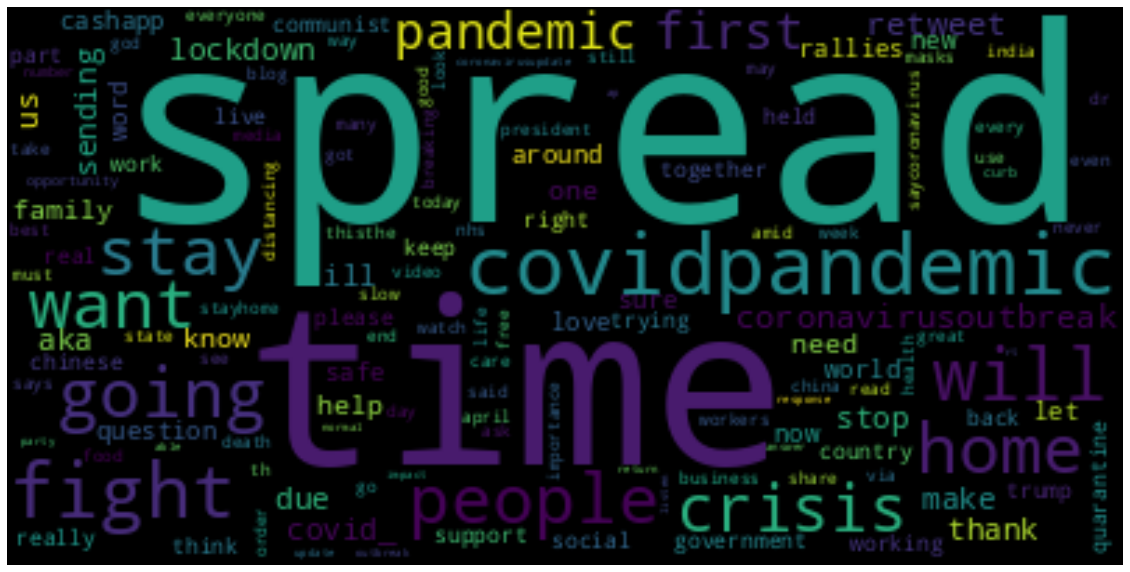

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Topic : Prevention
INFO : Saved Image of Confusion Matrix at  ./plot/wordcloud_prevention


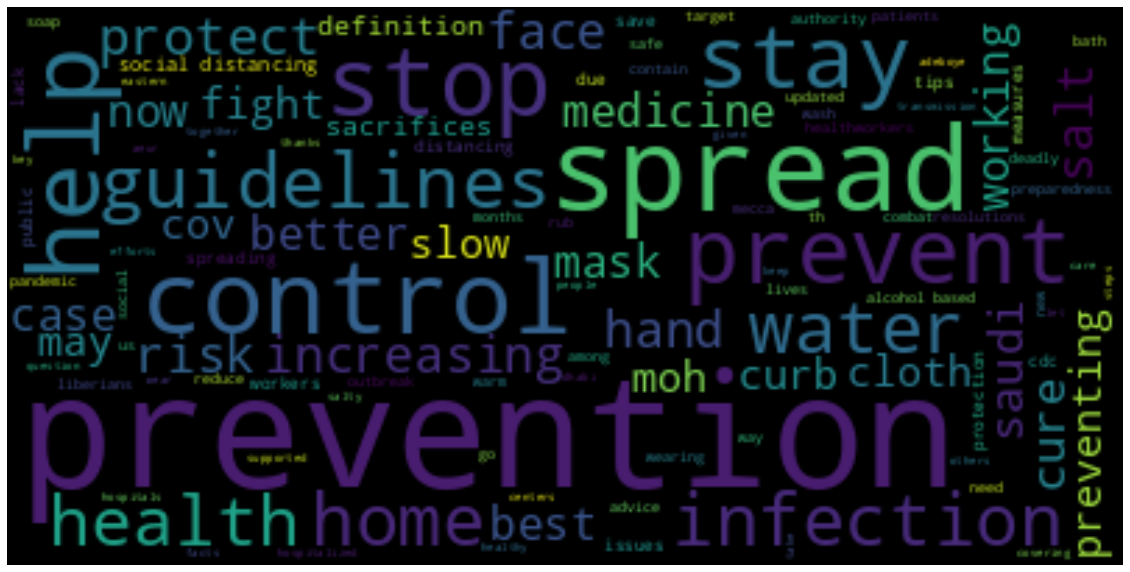

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Topic : Deaths_Reports
INFO : Saved Image of Confusion Matrix at  ./plot/wordcloud_deaths_reports


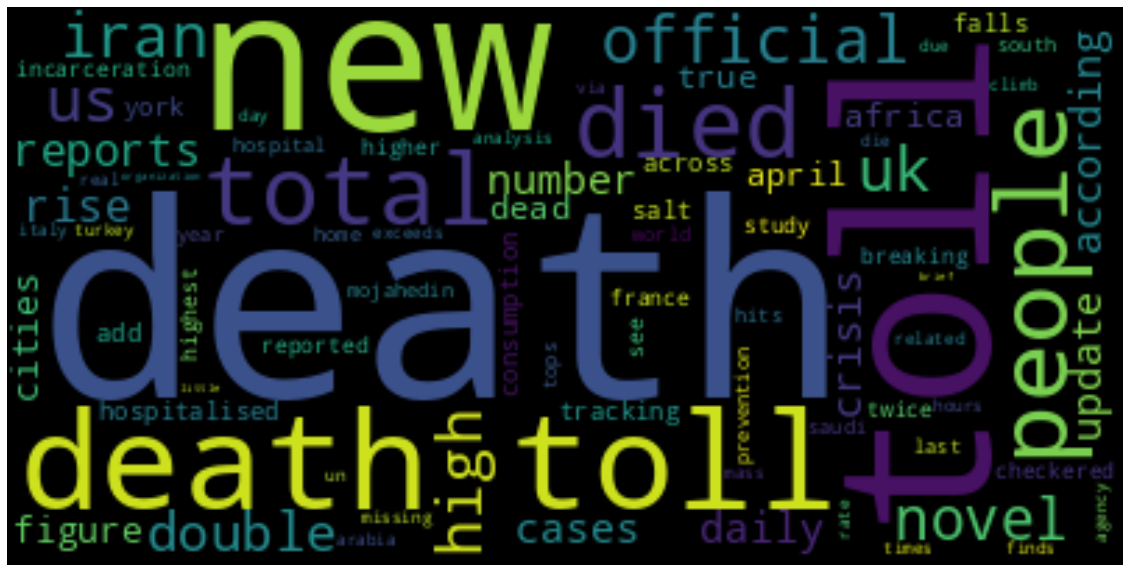

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Topic : Affected_People
INFO : Saved Image of Confusion Matrix at  ./plot/wordcloud_affected_people


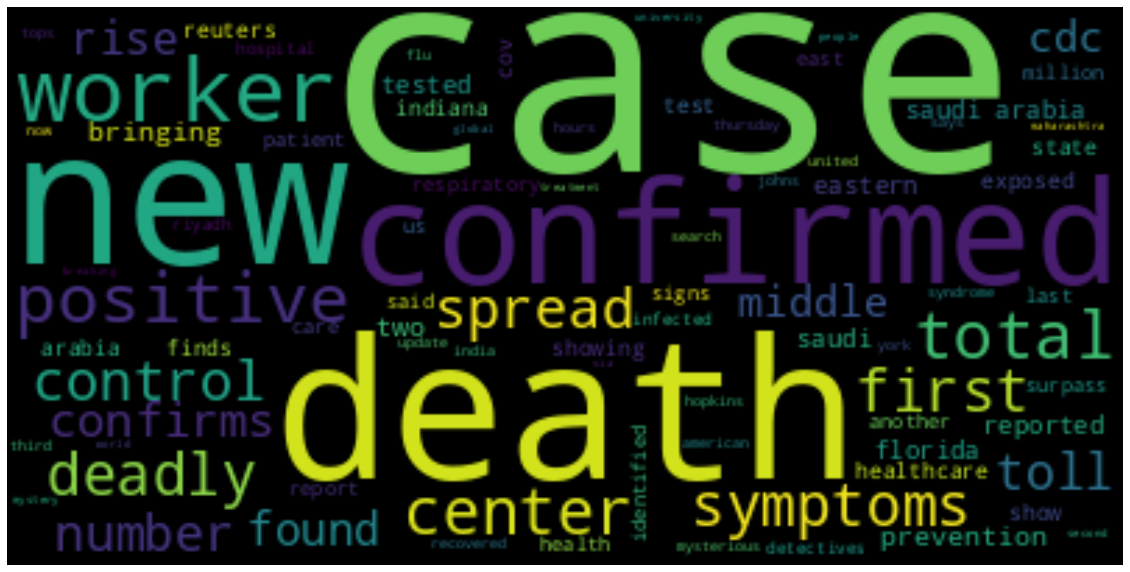

In [17]:
top = 200 # Top-M Scoring Words

for topic in df['topic'].unique():
    print('=+'*20)
    print(f'Topic : {topic.title()}')
    text_series = df[df['topic']==topic]['tweet_text']
    all_ngrams=''
    for n in range(1,4):
        top_ngrams = peek_tfidf(text_series, top=top, ngram_range=(n,n))['term'].values
        all_ngrams+= " ".join(top_ngrams)
    plot_wordcloud(all_ngrams, savefig_path=f'./plot/wordcloud_{topic}',)

## Sentiment Analysis

Sentiment Analysis reveals sensible insights.
- Overall Average Sentiment Score = -0.0175 (slight negative which makes sense as it's on diseases)
- By Topic, Death Reports yielded a significant negative score of -0.426.
- Prevention was the most positive +0.066.

In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [7]:
sia=SentimentIntensityAnalyzer()

In [11]:
df['sentiment']=df['tweet_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [65]:
# Overall Sentiment Score
avg_overall_score=df['sentiment'].mean()
print(f'INFO : Overall Average Sentiment Score is {avg_overall_score}')

INFO : Overall Average Sentiment Score is -0.017525743105483424


In [42]:
df_sentiment_topic=df.groupby('topic')['sentiment'].mean().sort_values()

In [48]:
df_sentiment_topic.index

Index(['deaths_reports', 'other_useful_information', 'disease_transmission',
       'disease_signs_or_symptoms', 'affected_people', 'treatment',
       'not_related_or_irrelevant', 'prevention'],
      dtype='object', name='topic')

INFO : Saved Image at  ./plot/barplot_sentiment.png


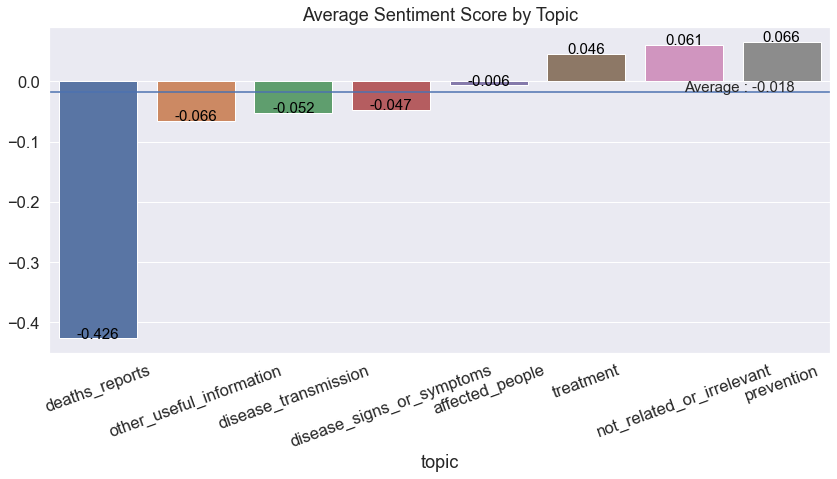

In [89]:
# plt.bar(x=range(len(df_sentiment_topic)), height=df_sentiment_topic.values, )
fig,ax = plt.subplots(figsize=(14, 6))
graph=sns.barplot(
    x=df_sentiment_topic.index,
    y=df_sentiment_topic.values, 
    ax=ax,   
)
graph.set_title('Average Sentiment Score by Topic')
sns.set(font_scale=1.25)
plt.xticks(rotation=20)
for n, (index, row) in enumerate(df_sentiment_topic.iteritems()):
    graph.text(n, row, round(row, 3), color='black', ha="center")
#Drawing a horizontal line at point 1.25
graph.axhline(avg_overall_score)
text_x=len(df_sentiment_topic)-2
text_val=f'Average : {str(round(avg_overall_score,3))}'
graph.text(text_x, avg_overall_score, text_val)

savefig_path='./plot/barplot_sentiment.png'
if savefig_path:
    try:
        plt.savefig(savefig_path, dpi=300, bbox_inches = "tight")
        print('INFO : Saved Image at ', savefig_path)
    except:
        print('WARNING : Failed to Save Image to ', savefig_path)
        
plt.show()

INFO : Saved Image at  ./plot/barplot_sentiment.png


<Figure size 432x288 with 0 Axes>